In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from collections import Counter
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Embedding, 
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
print(tf.config.list_physical_devices('GPU'))

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


# Data Exploration

In [3]:
data_directory = "data"
raw_data_directory = "raw-data"
model_saves_directory = "model-saves"
raw_data_path = os.path.join(raw_data_directory, "mental_health.csv")

In [4]:
raw_data_dataframe = pd.read_csv(raw_data_path)
raw_data_dataframe.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


## Visualize the samples per label count

In [5]:
label_counts = raw_data_dataframe['label'].value_counts()
label_counts

label
0    14139
1    13838
Name: count, dtype: int64

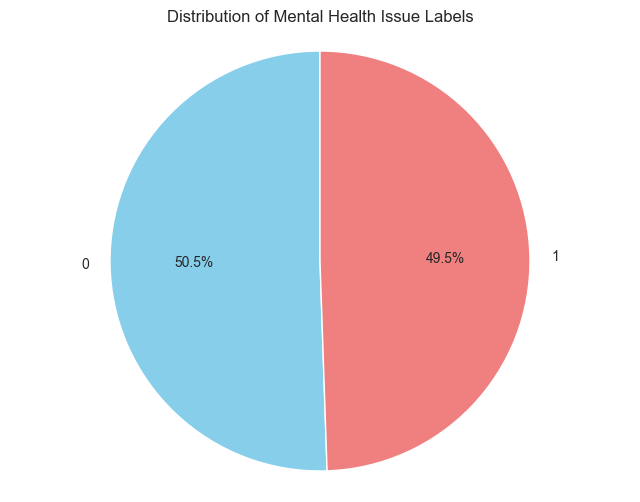

In [6]:
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Distribution of Mental Health Issue Labels')
plt.axis('equal')  
plt.show()

## Explore various features

In [7]:
raw_data_dataframe['word_count'] = raw_data_dataframe['text'].apply(lambda x: len(str(x).split()))
raw_data_dataframe['char_count'] = raw_data_dataframe['text'].apply(lambda x: len(str(x)))

raw_data_dataframe.head()

,text,label,word_count,char_count
0,dear american teens question dutch person hear...,0,23,135
1,nothing look forward lifei dont many reasons k...,1,20,117
2,music recommendations im looking expand playli...,0,64,450
3,im done trying feel betterthe reason im still ...,1,100,594
4,worried year old girl subject domestic physic...,1,311,2133


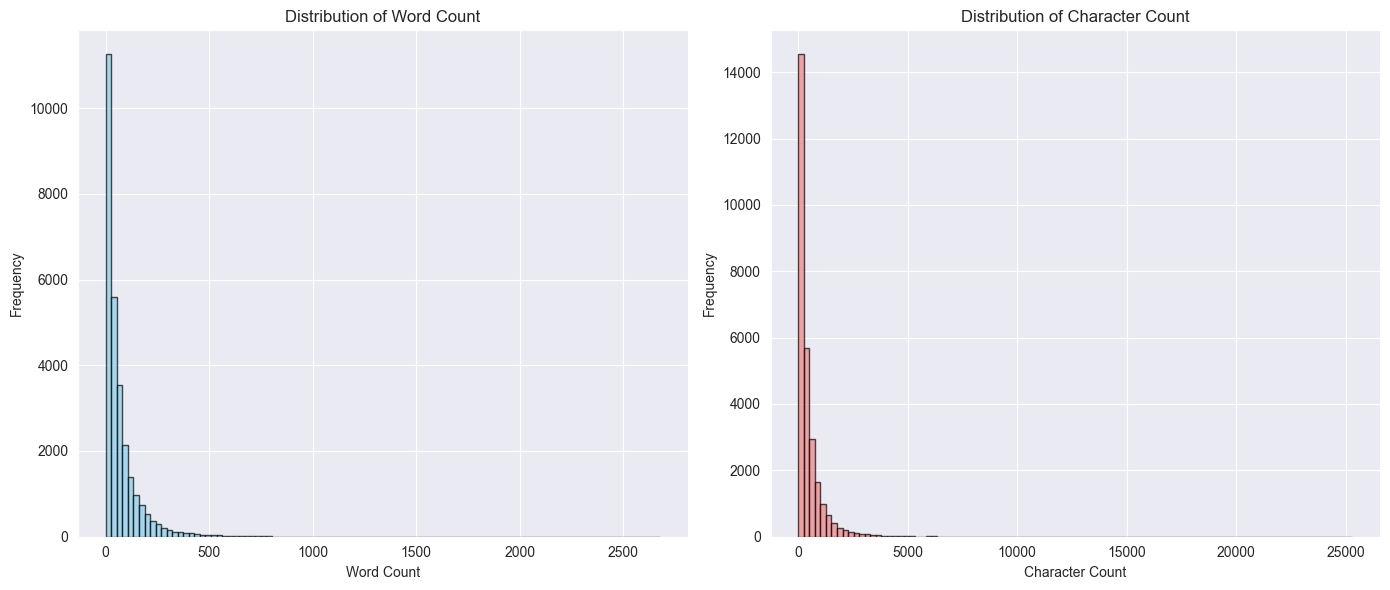

In [8]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) 
plt.hist(raw_data_dataframe['word_count'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2) 
plt.hist(raw_data_dataframe['char_count'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Preprocessing

## Lower text, remove urls, remove punctuation, remove stopwords, stemming

In [9]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    
    text = ' '.join(tokens)
    return text

In [10]:
raw_data_dataframe['text'] = raw_data_dataframe['text'].apply(preprocess_text)
raw_data_dataframe['word_count_after'] = raw_data_dataframe['text'].apply(lambda x: len(str(x).split()))
raw_data_dataframe['char_count_after'] = raw_data_dataframe['text'].apply(lambda x: len(str(x)))
raw_data_dataframe

,text,label,word_count,char_count,word_count_after,char_count_after
0,dear american teen question dutch person heard...,0,23,135,23,129
1,noth look forward lifei dont mani reason keep ...,1,20,117,19,95
2,music recommend im look expand playlist usual ...,0,64,450,61,384
3,im done tri feel betterth reason im still aliv...,1,100,594,96,512
4,worri year old girl subject domest physicalmen...,1,311,2133,296,1811
...,...,...,...,...,...,...
27972,post everyday peopl stop care religion matter ...,0,28,200,27,169
27973,okay definetli need hear guy opinion ive prett...,0,163,978,154,839
27974,cant get dog think ill kill myselfth last thin...,1,33,189,30,159
27975,what point princess bridei realli think like w...,1,96,603,93,524


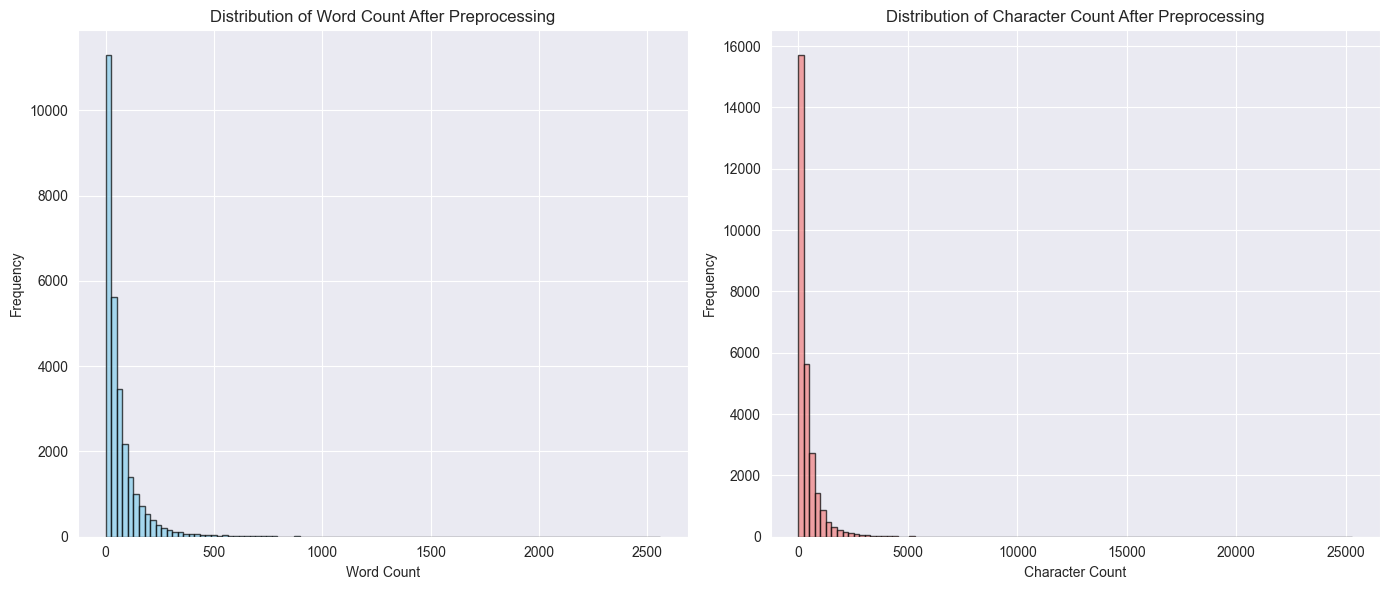

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) 
plt.hist(raw_data_dataframe['word_count_after'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Word Count After Preprocessing')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2) 
plt.hist(raw_data_dataframe['char_count_after'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Character Count After Preprocessing')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Visualizing textual data (pos tagging, most common words)

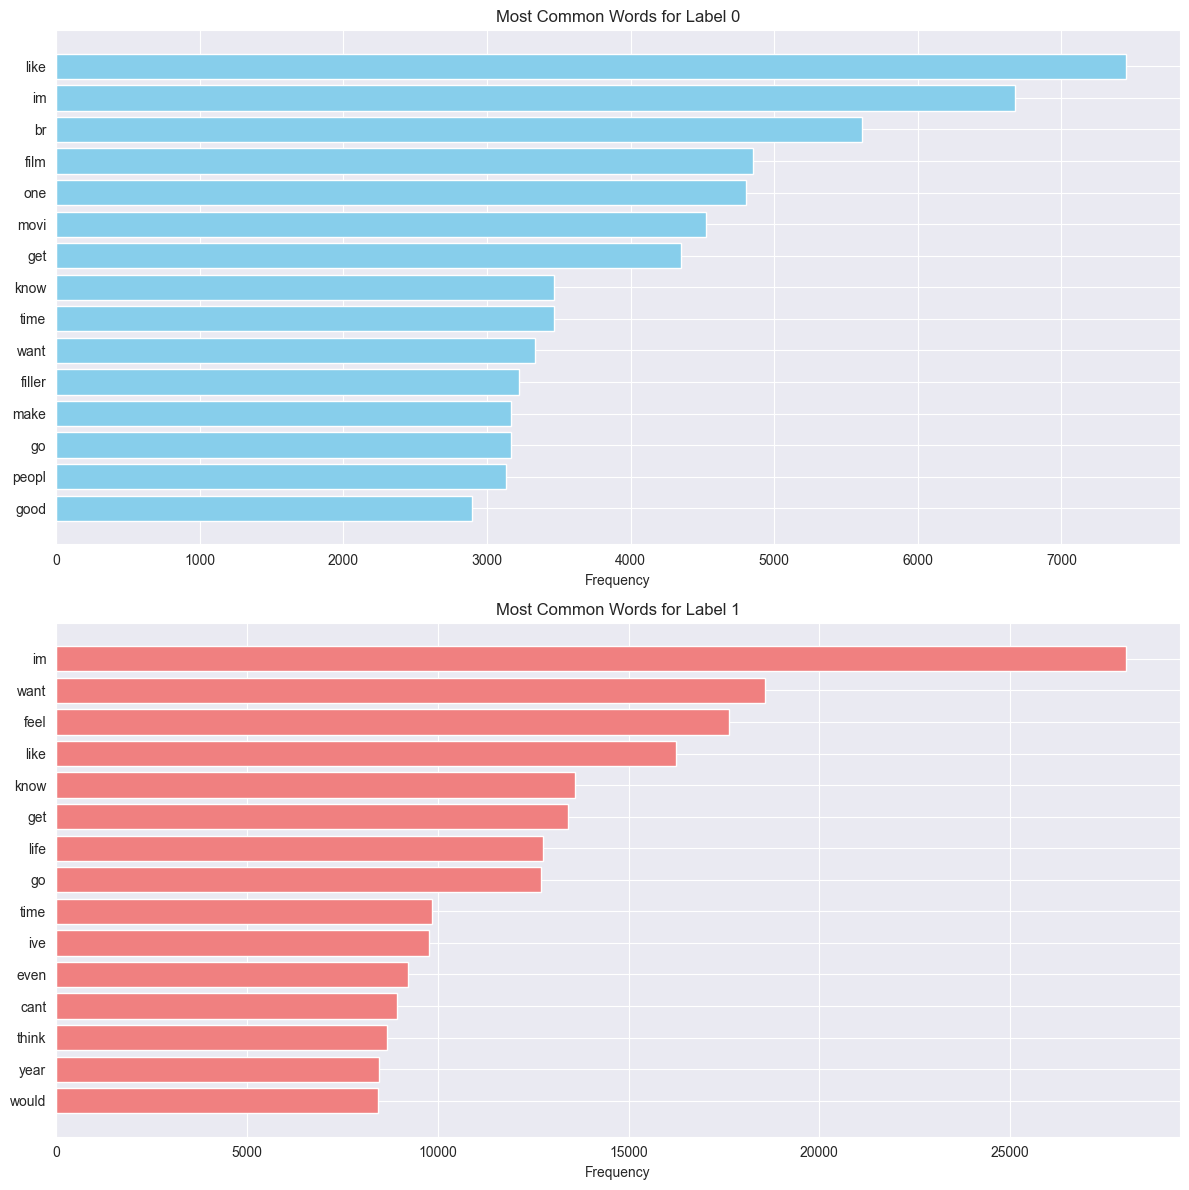

In [12]:
label_0_words = raw_data_dataframe[raw_data_dataframe['label'] == 0]['text'].str.split().sum()
label_1_words = raw_data_dataframe[raw_data_dataframe['label'] == 1]['text'].str.split().sum()

label_0_word_counts = Counter(label_0_words)
label_1_word_counts = Counter(label_1_words)

label_0_top_words = label_0_word_counts.most_common(15)
label_1_top_words = label_1_word_counts.most_common(15)

words_0, counts_0 = zip(*label_0_top_words)
words_1, counts_1 = zip(*label_1_top_words)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].barh(words_0, counts_0, color='skyblue')
axes[0].set_title('Most Common Words for Label 0')
axes[0].invert_yaxis() 
axes[0].set_xlabel('Frequency')

axes[1].barh(words_1, counts_1, color='lightcoral')
axes[1].set_title('Most Common Words for Label 1')
axes[1].invert_yaxis()  
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
def pos_tag_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens) 
    return [tag for word, tag in pos_tags]

In [14]:
raw_data_dataframe['pos_tags'] = raw_data_dataframe['text'].apply(pos_tag_text)
raw_data_dataframe.head()

,text,label,word_count,char_count,word_count_after,char_count_after,pos_tags
0,dear american teen question dutch person heard...,0,23,135,23,129,"[JJ, JJ, JJ, NN, NN, NN, VBD, NN, VB, NN, JJ, ..."
1,noth look forward lifei dont mani reason keep ...,1,20,117,19,95,"[DT, VBP, RB, JJ, NN, NN, NN, VB, VBP, VB, IN,..."
2,music recommend im look expand playlist usual ...,0,64,450,61,384,"[NN, NN, JJ, NN, VBP, NN, JJ, NN, NN, NN, NN, ..."
3,im done tri feel betterth reason im still aliv...,1,100,594,96,512,"[NN, VBN, NN, NN, IN, NN, NN, RB, RB, VBP, JJ,..."
4,worri year old girl subject domest physicalmen...,1,311,2133,296,1811,"[JJ, NN, JJ, NN, JJ, NN, NN, NN, VBP, NN, VBP,..."


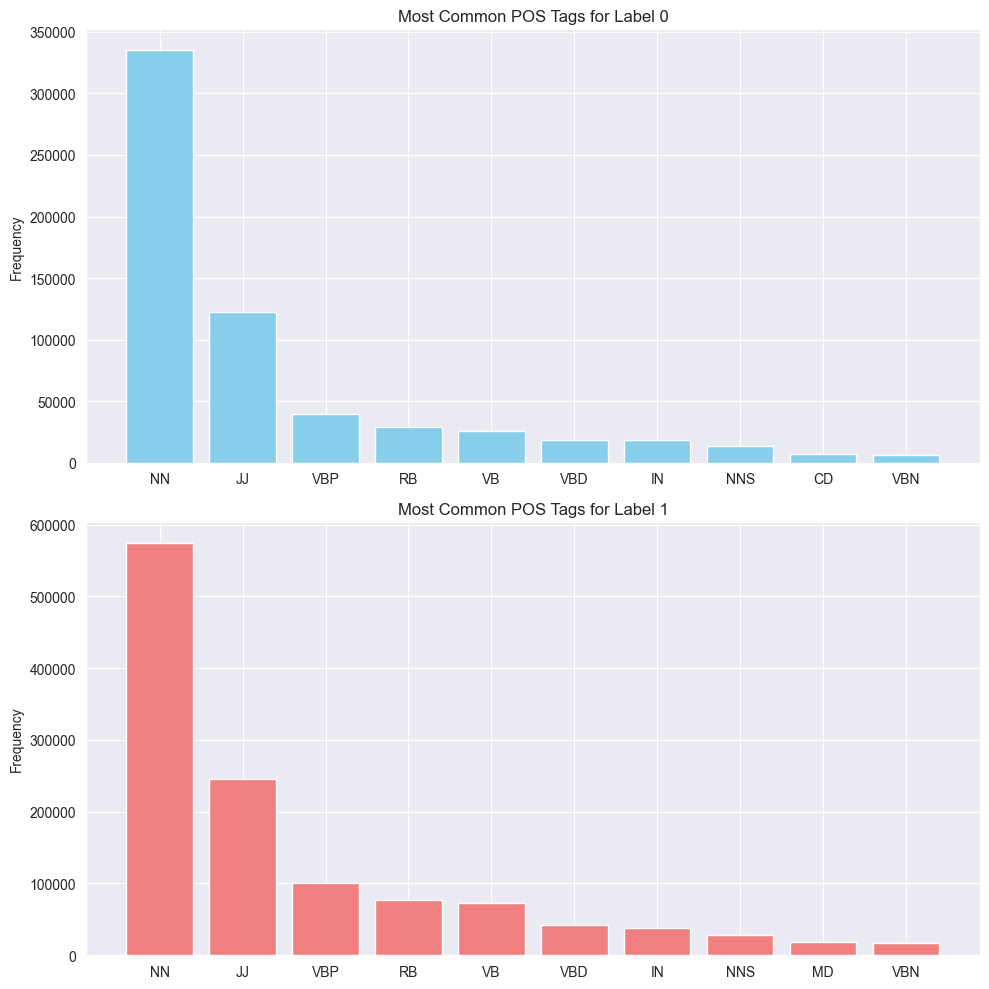

In [15]:
label_0_pos_tags = [tag for tags in raw_data_dataframe[raw_data_dataframe['label'] == 0]['pos_tags'] for tag in tags]
label_1_pos_tags = [tag for tags in raw_data_dataframe[raw_data_dataframe['label'] == 1]['pos_tags'] for tag in tags]

label_0_pos_counts = Counter(label_0_pos_tags)
label_1_pos_counts = Counter(label_1_pos_tags)

label_0_top_pos = label_0_pos_counts.most_common(10)
label_1_top_pos = label_1_pos_counts.most_common(10)

pos_tags_0, counts_0 = zip(*label_0_top_pos)
pos_tags_1, counts_1 = zip(*label_1_top_pos)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].bar(pos_tags_0, counts_0, color='skyblue')
axes[0].set_title('Most Common POS Tags for Label 0')
axes[0].set_ylabel('Frequency')

axes[1].bar(pos_tags_1, counts_1, color='lightcoral')
axes[1].set_title('Most Common POS Tags for Label 1')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Classification models

## Split data (training and testing/validation)

In [16]:
training_samples, testing_samples, training_labels, testing_labels = train_test_split(raw_data_dataframe['text'], raw_data_dataframe['label'], test_size=0.2, random_state=42)

print(f'Training data size: {len(training_samples)}')
print(f'Testing data size: {len(testing_samples)}')

Training data size: 22381
Testing data size: 5596


In [17]:
training_samples[0], training_labels[0]

('dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math',
 0)

## CNN

In [19]:
max_sequence_length = 25000

tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(training_samples)

training_sequences = tokenizer.texts_to_sequences(training_samples)
testing_sequences = tokenizer.texts_to_sequences(testing_samples)

training_sequences_padded = pad_sequences(training_sequences, maxlen=max_sequence_length)
testing_sequences_padded = pad_sequences(testing_sequences, maxlen=max_sequence_length)

vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

47107

In [20]:
total_words = sum(len(seq) for seq in training_sequences + testing_sequences)
covered_words = sum(len([word for word in seq if word < vocabulary_size]) for seq in training_sequences + testing_sequences)

coverage_percentage = (covered_words / total_words) * 100
print(f"Vocabulary Coverage: {coverage_percentage:.2f}%")

Vocabulary Coverage: 100.00%


In [25]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.9,
    staircase=True
)

cnn_model = Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_sequence_length),
        Conv1D(filters=4, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=8, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=16, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"), 
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

cnn_model_history = cnn_model.fit(
  training_sequences_padded, training_labels,
  epochs = 5,
  batch_size=32,
  validation_data=(testing_sequences_padded, testing_labels)
)

Epoch 1/5
700/700 [==============================] - 47s 65ms/step - loss: 0.3414 - accuracy: 0.8544 - val_loss: 0.2216 - val_accuracy: 0.9169
Epoch 2/5
700/700 [==============================] - 46s 65ms/step - loss: 0.1874 - accuracy: 0.9345 - val_loss: 0.2157 - val_accuracy: 0.9162
Epoch 3/5
700/700 [==============================] - 46s 65ms/step - loss: 0.1307 - accuracy: 0.9559 - val_loss: 0.2463 - val_accuracy: 0.9105
Epoch 4/5
700/700 [==============================] - 46s 66ms/step - loss: 0.0921 - accuracy: 0.9693 - val_loss: 0.2872 - val_accuracy: 0.9094
Epoch 5/5
700/700 [==============================] - 46s 66ms/step - loss: 0.0677 - accuracy: 0.9768 - val_loss: 0.3330 - val_accuracy: 0.9071


In [26]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25000, 100)        4710700   
                                                                 
 conv1d_12 (Conv1D)          (None, 24999, 4)          804       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 12499, 4)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 12498, 8)          72        
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 6249, 8)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 6248, 16)         

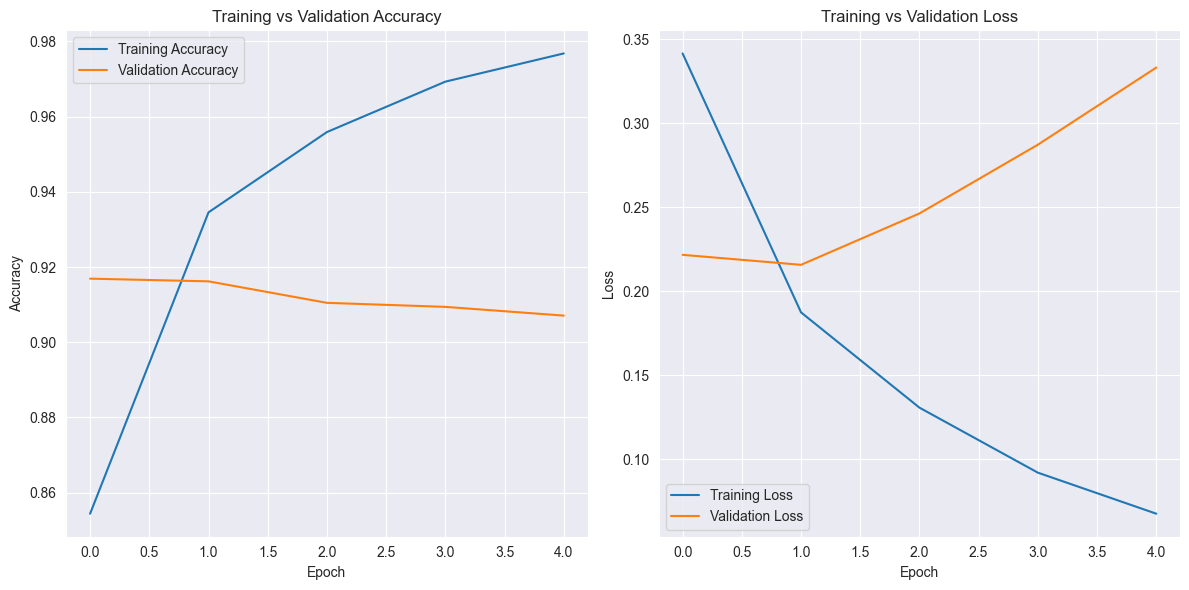

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_model_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

175/175 [==============================] - 4s 19ms/step


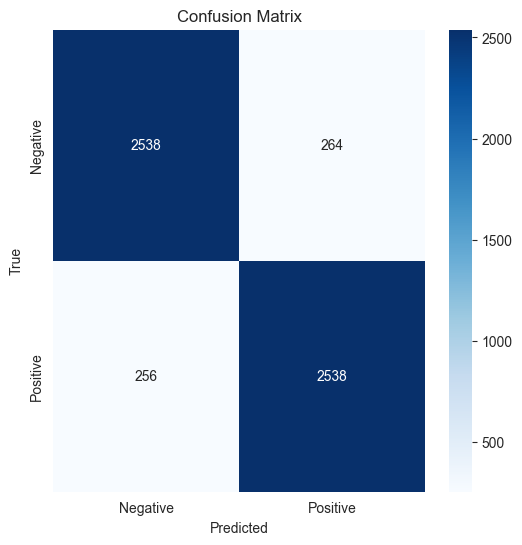

In [28]:
predictions = cnn_model.predict(testing_sequences_padded)
predictions = (predictions > 0.5).astype(int) 

cm = confusion_matrix(testing_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [143]:
cnn_model.save(os.path.join(model_saves_directory, 'cnn_text_classification_model.h5'))

## Random Forest

In [135]:
vectorizer = TfidfVectorizer(max_features= 500, min_df= 2)

non_cnn_training_samples = vectorizer.fit_transform(training_samples).toarray()
non_cnn_testing_samples = vectorizer.fit_transform(testing_samples).toarray()

In [96]:
non_cnn_testing_samples[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 42 stored elements and shape (1, 3000)>

In [139]:
random_forest_parameters_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [None]
}

random_forest_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_parameters_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(non_cnn_training_samples, training_labels)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_depth': None, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.8835


Random Forest Accuracy (Best Parameters): 0.7103


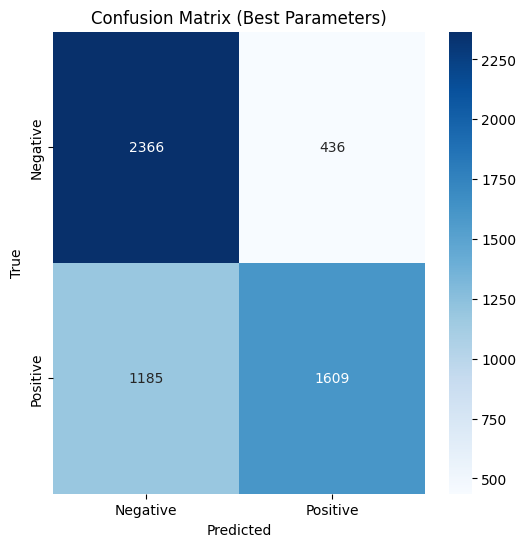

In [140]:
best_random_forest_model = grid_search.best_estimator_
random_forest_predictions = best_random_forest_model.predict(non_cnn_testing_samples)

random_forest_accuracy = accuracy_score(testing_labels, random_forest_predictions)
print(f'Random Forest Accuracy (Best Parameters): {random_forest_accuracy:.4f}')

random_forest_cm = confusion_matrix(testing_labels, random_forest_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(random_forest_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Best Parameters)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Ridge Classifier

In [137]:
ridge_parameters_grid = {
    'alpha': [5, 10, 15, 20, 50, 100],
    'max_iter': [50, 100, 200],
    'solver': ['auto']
}

ridge_model = RidgeClassifier()

grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=ridge_parameters_grid, 
                                 cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search_ridge.fit(non_cnn_training_samples, training_labels)

print(f'Best Parameters for Ridge Classifier: {grid_search_ridge.best_params_}')
print(f'Best Cross-Validation Accuracy: {grid_search_ridge.best_score_:.4f}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for Ridge Classifier: {'alpha': 5, 'max_iter': 50, 'solver': 'auto'}
Best Cross-Validation Accuracy: 0.8961


Ridge Classifier Accuracy (Best Parameters): 0.7513


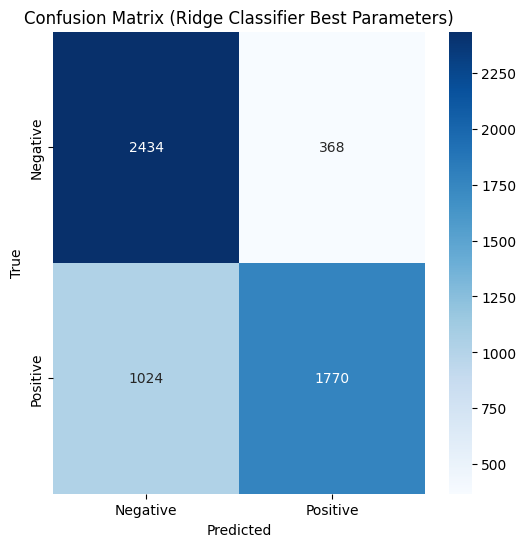

In [138]:
best_ridge_model = grid_search_ridge.best_estimator_
ridge_predictions = best_ridge_model.predict(non_cnn_testing_samples)

ridge_accuracy_best = accuracy_score(testing_labels, ridge_predictions)
print(f'Ridge Classifier Accuracy (Best Parameters): {ridge_accuracy_best:.4f}')

ridge_cm = confusion_matrix(testing_labels, ridge_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(ridge_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Ridge Classifier Best Parameters)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Naive Bayes

Naive Bayes Classifier Accuracy: 0.7513


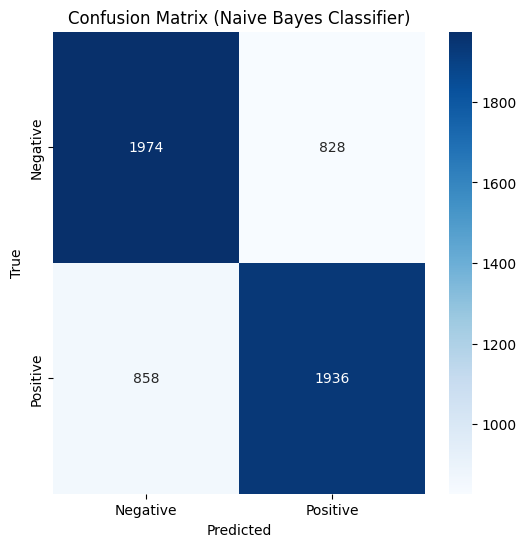

In [141]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(non_cnn_training_samples, training_labels)

naive_bayes_predictions = naive_bayes_model.predict(non_cnn_testing_samples)

naive_bayes_accuracy_best = accuracy_score(testing_labels, naive_bayes_predictions)
print(f'Naive Bayes Classifier Accuracy: {ridge_accuracy_best:.4f}')

naive_bayes_cm = confusion_matrix(testing_labels, naive_bayes_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(naive_bayes_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Naive Bayes Classifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()